This notebook aims at advancing faster in incorporating a monthly generator to a Django website.

In [1]:
import sys
print (sys.version)

3.5.1 (default, Jan 11 2016, 11:13:34) 
[GCC 4.9.2]


# Discovering Django objects

In [1]:
Creation.objects.all()

[<Creation: Brussels, Cinquantenaire>]

In [3]:
Creation.objects.get(id=1)

<Creation: Brussels, Cinquantenaire>

# Generating a postcard

Recall https://github.com/Utopiah/CC2015Goal3Month1/blob/master/BlendMeAPicture.py 

Unfortunally Google Search API is deprecated, see instead https://console.developers.google.com with their Python client https://github.com/google/google-api-python-client (see also https://developers.google.com/apis-explorer/#p/customsearch/v1/search.cse.list?q=brussels&_h=1& for test but requires they key)

In [4]:
import urllib.request
import json
def addImageToLibrary(keyword, amount):
    searchUrl = "http://api.pixplorer.co.uk/image?word=" + keyword + "&size=tb&amount=" + str(amount)
    with urllib.request.urlopen(searchUrl) as response:
        myJson = response.read().decode('utf-8')
        deserialized_output = json.loads(str(myJson))
    return  deserialized_output

In [5]:
#images = addImageToLibrary("sri+lanka", 10)
#for image in images["images"]:
#    print(image["imageurl"])

# What this postcard generator should do
1. receive keywords from user, if no find at least 2 that are contextual (geologicating user or calendar or worldwide news)
1. fetch at least 1 image per keyword
 1. https://www.instagram.com/developer/ with https://github.com/Instagram/python-instagram
 1. https://developers.google.com/custom-search/json-api/v1/overview with https://developers.google.com/api-client-library/python/apis/customsearch/v1?hl=en
 1. http://pixplorer.co.uk (not with https://github.com/michaeldegroot/pixplorer-api as its Node)
1. check if that blend already exists, if so go back to #2 if not generate
1. server the result to the user allowing him to fork or use as postcard (automatically voting it up and marking the result as used so that it does not get generated again)

In [6]:
from PIL import Image
import io
def getImageFromUrl(imageurl):
    fd = urllib.request.urlopen(imageurl)
    image_file = io.BytesIO(fd.read())
    return Image.open(image_file)
    # might be costly, when and how can it be closed later on?

In [7]:
def loadingImages(images, limit):
    db = images["images"]
    loadedImages = []
    for imageIndex in range(0, limit):
        loadedImages.append(getImageFromUrl(db[imageIndex]["imageurl"]))
    return loadedImages

In [8]:
def imagesBlend(loadedImages, imageSize, opacity):
    # limited to 2 images only
    cleanDB = []
    for image in loadedImages:
        resizedImage = image.resize((imageSize, imageSize))
        coherentImage = resizedImage.convert('RGBA')
        cleanDB.append(coherentImage)
    return Image.blend(cleanDB[0], cleanDB[1], opacity)

In [9]:
def blendImagesFromTheme(Theme, imageSize=50, opacity=0.7):
    # deprecated, use instead blendImagesFromTheme that handles one or more themes
    result = blendImagesFromThemes([Theme], imageSize, opacity)
    # best solution but defined later on
    #images = addImageToLibrary(Theme, 10)
    #loadedImages = loadingImages(images, 2)
    #result = imagesBlend(loadedImages, imageSize, opacity)
    return result

In [10]:
#blendImagesFromTheme("Brussels")

In [11]:
#blendImagesFromTheme("Sri+Lanka")

In [12]:
#blendImagesFromTheme("Potato")

## Working blender for one theme

In [13]:
Creation.objects.get(id=1)

<Creation: Brussels, Cinquantenaire>

In [14]:
Themes = str(Creation.objects.get(id=1)).split(', ')

In [15]:
Themes

['Brussels', 'Cinquantenaire']

In [16]:
#blendImagesFromTheme(Themes[1])

## Blending from multiple themes

In [17]:
def blendImagesFromThemes(Themes, imageSize=50, opacity=0.7):
    loadedImages = []
    for Theme in Themes:
        #for the moment assuming 2 themes only
        images = addImageToLibrary(Theme, 10)
        if len(Themes) == 1:
            loadedImages.extend(loadingImages(images, 2))
        else:
            loadedImages.extend(loadingImages(images, 1))
    result = imagesBlend(loadedImages, imageSize, opacity)
    return result

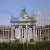

In [18]:
blendImagesFromThemes(Themes)

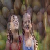

In [19]:
blendImagesFromThemes(['Potato','Photo'])

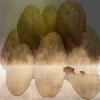

In [20]:
blendImagesFromThemes(['Potato','Photo'], imageSize=100, opacity=0.7)

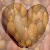

In [21]:
blendImagesFromThemes(['Potato'])

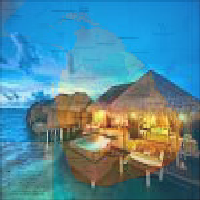

In [22]:
blendImagesFromThemes(['Sri+Lanka','Maldives'], imageSize=200, opacity=0.7)

## Saving a creation back to the database and making it available to the user
Update the database accordingly with 
* image file path
* used URLs
* blending paramaters
* date
* requesting user

https://docs.python.org/3/library/stdtypes.html#dict

In [23]:
def blendNewImagesFromThemes(Themes, imageSize=50, opacity=0.7):
    loadedImages = []
    for Theme in Themes:
        #for the moment assuming 2 themes only
        images = addImageToLibrary(Theme, 10)
        if len(Themes) == 1:
            loadedImages.extend(loadingImages(images, 2))
        else:
            loadedImages.extend(loadingImages(images, 1))
    result = dict(image=imagesBlend(loadedImages, imageSize, opacity), 
                  theme=Themes, 
                  imageSize=imageSize, 
                  opacity=opacity,
                  filePath='',
                  usedURLS=[])
    return result

result = blendNewImagesFromThemes(['Sri+Lanka','Maldives'], imageSize=200, opacity=0.7)

#print(result.filePath)
#print(result.usedURLs) # []
#print(result.blendingParameters) # object?

#Unlinked to a user so far!
#print(result.date)
#print(result.requestingUser)

{'opacity': 0.7, 'image': <PIL.Image.Image image mode=RGBA size=200x200 at 0x7F252497E7F0>, 'usedURLS': [], 'imageSize': 200, 'theme': ['Sri+Lanka', 'Maldives'], 'filePath': ''}


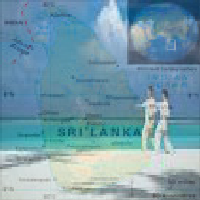

In [24]:
print(result)

result['image']

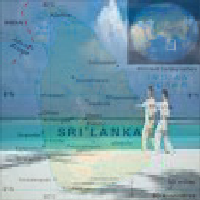

In [25]:
file_path = 'test.bmp'
result['image'].save(file_path)
img = Image.open(file_path)
img

In [1]:
from django.db import connection
# via http://stackoverflow.com/questions/3207859/django-how-do-i-get-every-table-and-all-of-that-tables-columns-in-a-project
table_info = []
tables = connection.introspection.table_names()
seen_models = connection.introspection.installed_models(tables)
for model in seen_models:
    table = model._meta.db_table
    columns = [field.column for field in model._meta.fields]
    table_info.append((table, columns))
    
for item in table_info:
    print(item)
    
print("\nAll creation", Creation.objects.all())

creation1 = Creation.objects.get(id=1)
print("\Creation 1", creation1)
print(creation1.pub_date)
print(creation1.desired_format_id)
print(creation1.parent_id)
print(creation1.user_id)

print("\nAll formats", Desired_Format.objects.all())
print(Desired_Format.objects.get(id=creation1.desired_format_id))

print("\nAll users", User.objects.all())
print(User.objects.get(id=creation1.user_id))

('auth_permission', ['id', 'name', 'content_type_id', 'codename'])
('django_admin_log', ['id', 'action_time', 'user_id', 'content_type_id', 'object_id', 'object_repr', 'action_flag', 'change_message'])
('django_session', ['session_key', 'session_data', 'expire_date'])
('auth_group', ['id', 'name'])
('django_content_type', ['id', 'app_label', 'model'])
('monthlyinterface_creation', ['id', 'image_size', 'opacity', 'file_path', 'user_id', 'desired_theme', 'pub_date', 'desired_format_id', 'parent_id'])
('monthlyinterface_desired_format', ['id', 'name'])
('monthlyinterface_material', ['id', 'desired_format_id', 'file_path', 'source_url'])
('auth_user', ['id', 'password', 'last_login', 'is_superuser', 'username', 'first_name', 'last_name', 'email', 'is_staff', 'is_active', 'date_joined'])

All creation [<Creation: Brussels, Cinquantenaire>]
\Creation 1 Brussels, Cinquantenaire
2016-01-04 08:27:14+00:00
1
None
1

All formats [<Desired_Format: Postcard>]
Postcard

All users [<User: admin>]
adm

In [35]:
Material.objects.all()
#m1 = Material(filePath='./test1.png', desired_format=Desired_Format.objects.get(id=1))
#dir(m1)
#m1.save() #enough copies...
Material.objects.all()
m1 = Material.objects.get(id=1)
Material.objects.get(id=1).file_path
m2 = Material.objects.get(id=2)

Material.objects.all()
c1 = Creation.objects.get(id=1)
#c1.materials.add(m1)
#c1.materials.add(m2)
#c1.materials
#c1.save()
c1.materials.all()
c1.materials.count()

[c1.materials.get(id=1).file_path, c1.materials.get(id=2).file_path]

def isMaterialPresent(materialURL):
    matches = Material.objects.filter(source_url=materialURL).count()
    if (matches>0):
        return True
    else :
        return False

isMaterialPresent('te')

False

## How to shorten the feedback loop to respect IoP?

* Is there more than 1 step required to get the result?
* If so what are those steps?
* Have to send command...
* first time I play with a new object or API I should display most if not all the internals

### Ressources
* Jupyter Keyboard Shortcuts https://sowingseasons.com/blog/reference/2016/01/jupyter-keyboard-shortcuts/23298516
* Livecoding (fixing the need to return) https://github.com/inkandswitch/livebook
* how to extend https://mindtrove.info
* learning %whos and more http://pages.physics.cornell.edu/~myers/teaching/ComputationalMethods/python/ipython.html

### Identified problems
* hidden internal structure
* result just at the bottom (necessarily a problem?)


In [40]:
%whos function

Variable                   Type        Data/Info
------------------------------------------------
IsMaterialPresent          function    <function IsMaterialPresent at 0x7f25249181e0>
addImageToLibrary          function    <function addImageToLibrary at 0x7f252595cc80>
blendImagesFromTheme       function    <function blendImagesFromTheme at 0x7f2524ff2488>
blendImagesFromThemes      function    <function blendImagesFrom<...>Themes at 0x7f2525980bf8>
blendNewImagesFromThemes   function    <function blendNewImagesF<...>Themes at 0x7f2524986d08>
getImageFromUrl            function    <function getImageFromUrl at 0x7f252595cea0>
imagesBlend                function    <function imagesBlend at 0x7f2524ff20d0>
isMaterialPresent          function    <function isMaterialPresent at 0x7f2524918840>
loadingImages              function    <function loadingImages at 0x7f2525980840>


## Generating another creation from the same themes
Later on the "Fork and generate from" button